In [6]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
import tensorflow_addons as tfa
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))
if os.path.abspath('../../tf2-gradient-checkpointing') not in sys.path:
    sys.path.append(os.path.abspath('../../tf2-gradient-checkpointing'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
from automatic_speech_recognition.utils import (wrap_call_methods, select_layers, 
                                                apply_dense, remove_dropouts, apply_lstm,
                                                merge_dense_dense, merge_dense_lstm,
                                                merge_neighbor_layers, get_renamed_model,
                                                get_model_prefixes)
from automatic_speech_recognition.dataset import ModelOutputsDataset
from automatic_speech_recognition.model import maxvol
import time
from datetime import datetime
import argparse
import pickle
from checkpointing import checkpointable
from functools import partial
from transform_model import transform
from tqdm import tqdm
from tensorflow.keras import layers
import seaborn as sns
sns.set()

from collections.abc import Iterable, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from h5_to_tflite import TF_CUSTOM_OBJECTS

from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.mixed_precision import experimental as mixed_precision

import horovod.tensorflow.keras as hvd

#%load_ext tensorboard
#%tensorboard --logdir=./models/ --port=32779

In [5]:
# !!!ONLY RUN ONCE AT THE START
deepspeech = asr.model.load_mozilla_deepspeech('./data/myfrozen.pb', verbose=False)
deepspeech.summary()

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

## Define pipeline code

In [7]:
def get_pipeline(model, optimizer=None):
    alphabet = asr.text.Alphabet(lang='en')
    features_extractor = asr.features.TfMFCC(
        features_num=26,
        winlen=0.032,
        winstep=0.02,
    )
    if not optimizer:
        optimizer = tf.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
    decoder = asr.decoder.GreedyDecoder()
    pipeline = asr.pipeline.CTCPipeline(
        alphabet, features_extractor, model, optimizer, decoder
    )
    return pipeline

def get_optimizer():
    opt_instance = tfa.optimizers.NovoGrad(0.0, beta_1=0.95, beta_2=0.5, weight_decay=0.001)
    return hvd.DistributedOptimizer(opt_instance)

def find_activations(model, dataset_idx, size_limit=None, verbose=False):
    dataset = asr.dataset.Audio.from_csv(dataset_idx, batch_size=1, use_filesizes=True, librosa_read=False)
    dataset.sort_by_length()
    dataset.shuffle_indices()
    dataset = ModelOutputsDataset(get_pipeline(model), dataset)

    activations = []
    num_activations = 0
    for i, (_, output) in enumerate(dataset):
        output = (output
                  .cpu()
                  .numpy()
                  .reshape(-1, output.shape[-1]))
        activations.append(output)
        num_activations += len(activations[-1])    
        if size_limit is not None and num_activations >= size_limit:
            break
        if verbose and i % 50 == 0:
            print(f"Calculated batch {i} out of {len(dataset)}")
    
    activations = np.concatenate(activations)
    if size_limit is not None:
        activations = activations[:size_limit]
        
    return activations

def svd_activations(model, dataset_idx, num_rows=None, verbose=False, return_activations=False, **kwargs):
    activations = find_activations(model, dataset_idx, size_limit=num_rows, verbose=verbose)
    
    if return_activations:
        return np.linalg.svd(activations, **kwargs), activations
    else:
        return np.linalg.svd(activations, **kwargs)

In [8]:
!mkdir layer_activations

mkdir: cannot create directory ‘layer_activations’: File exists


In [9]:
# dense_tails = ['conv2d', 'dense_2', 'dense_3', 'dense_4', 'dense_5']
# singular_values = []

# fig, axes = plt.subplots(5, 1, figsize=(13, 40))
# axes = axes.ravel()
# for prefix_model, tail_name, ax in zip(get_model_prefixes(deepspeech, tail_names=dense_tails), dense_tails, axes):
#     (_, cur_sigmas, vt), activs = svd_activations(prefix_model, './data/dev-clean-index.csv', 100000, full_matrices=False, return_activations=True)
#     singular_values.append(cur_sigmas)
#     np.save(f'layer_activations/{tail_name}.npy', activs)
#     np.save(f'layer_activations/vt_{tail_name}.npy', vt)
    
#     ax.set_title(f'Singular values for {tail_name}')
#     ax.set_yscale('log')
#     ax.scatter(range(len(cur_sigmas)), cur_sigmas/cur_sigmas[0], s=2)

# relu_tails = ['re_lu', 're_lu_1', 're_lu_2', 'lstm_1', 're_lu_3']
# singular_values = []

# fig, axes = plt.subplots(5, 1, figsize=(13, 40))
# axes = axes.ravel()
# for prefix_model, tail_name, ax in zip(get_model_prefixes(deepspeech, tail_names=relu_tails), relu_tails, axes):
#     (_, cur_sigmas, vt), activs = svd_activations(prefix_model, './data/dev-clean-index.csv', 100000, full_matrices=False, return_activations=True)
#     singular_values.append(cur_sigmas)
#     np.save(f'layer_activations/{tail_name}.npy', activs)
#     np.save(f'layer_activations/vt_{tail_name}.npy', vt)
    
#     ax.set_title(f'Singular values for {tail_name}')
#     ax.set_yscale('log')
#     ax.scatter(range(len(cur_sigmas)), cur_sigmas/cur_sigmas[0], s=2)

In [10]:
# ! pip install maxvolpy

# from maxvolpy.maxvol import rect_maxvol, maxvol
# import os
# import numpy as np

# ranks = [100, 300, 500, 700, 750, 1000, 1200, 1300, 1400, 1500, 1700] 
# for rank in ranks:
#     for filename in os.listdir('./layer_activations'):
#         if not filename.startswith('vt_'):
#             continue
#         name = filename[3:-4]
#         vt = np.load(f'./layer_activations/{filename}')
#         v = vt[:rank].T
#         piv, C = rect_maxvol(v, start_maxvol_iters=1000, tol=1.01, maxK=2*rank)
#         np.save(f"./layer_activations/2vol_maxvolrows_{name}_r{rank}.npy", piv)
#         piv, C = maxvol(v, max_iters=1000, tol=1.01)
#         np.save(f"./layer_activations/1vol_maxvolrows_{name}_r{rank}.npy", piv)

### Maxvol for deepspeech

In [11]:
def evaluate(model, dataset_idx='./data/dev-clean-index.csv'):
    pipeline = get_pipeline(model)
    dataset = asr.dataset.Audio.from_csv(dataset_idx, batch_size=10, use_filesizes=True, librosa_read=False)
    dataset.sort_by_length()
    pipeline.compile_model()

    dataset = pipeline.wrap_preprocess(dataset)
    loss = model.evaluate(dataset)
    
    test_dataset = asr.dataset.Audio.from_csv(dataset_idx, batch_size=10, use_filesizes=True, librosa_read=False)
    dataset.sort_by_length()
    wer, cer = asr.evaluate.calculate_error_rates(pipeline, test_dataset)
    return loss, wer, cer

def get_maxvolled_deepspeech(deepspeech_model, rank, tol, change_layers=None, maxvol_type='2vol'):
    assert maxvol_type in ('2vol', '1vol')
    if change_layers is None:
        change_layers = ['conv2d', 'dense_2', 'dense_3', 'dense_4', 'lstm_1']
    
    # clone model and rename layers to avoid problems arising from graph manipulations
    deepspeech_ = get_renamed_model(deepspeech_model)
    # get input of a model. Without fixing, InputLayers break process of iterating over model
    layers = deepspeech_.layers
    start_layer = 0
    if isinstance(layers[0], keras.layers.InputLayer):
        output = layers[0].output
        start_layer = 1
    else:
        output = deepspeech_.input    

    for i in range(start_layer, len(layers)):
        if deepspeech_model.layers[i].name == 'lstm_1' and 'lstm_1' in change_layers:
            compact_v = np.load(f'./layer_activations/vt_lstm_1.npy')[:rank].T
            maxvol_idxs = np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_lstm_1_r{rank}.npy')
            output = maxvol.apply_maxvol_decomposed_lstm(output, layers[i], compact_v, maxvol_idxs)
#         elif deepspeech_model.layers[i].name == 'conv2d' and 'conv_2d' in change_layers:
#             compact_v = np.load(f'./layer_activations/vt_lstm_1.npy')[:rank].T
#             maxvol_idxs = np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_lstm_1_r{rank}.npy')
#             output = maxvol.apply_maxvol_decomposed_conv(output, layers[i], compact_v, maxvol_idxs)
        elif i + 1 < len(layers) and deepspeech_model.layers[i].name in change_layers:
            assert isinstance(layers[i + 1], keras.layers.ReLU), f"Specified layers should ReLu layers instead it is {layers[i+1]}"
            assert isinstance(layers[i], keras.layers.Dense), f"Layer before specified ReLu should be Dense and it is {layers[i]}"
            relu_name = deepspeech_model.layers[i + 1].name
            
            compact_v = np.load(f'./layer_activations/vt_{relu_name}.npy')[:rank].T
            maxvol_idxs = np.load(f'./layer_activations/{maxvol_type}_tol{tol}_maxvolrows_{relu_name}_r{rank}.npy')
            output = maxvol.apply_maxvol_decomposed_dense(output, 
                                                dense_layer=layers[i], 
                                                activation=layers[i + 1], 
                                                compact_v=compact_v,
                                                maxvol_idxs=maxvol_idxs)
        
        else:
            output = layers[i](output)
        
    result_model = keras.Model(deepspeech_.input, output)
    result_model = get_renamed_model(result_model)
    result_model = merge_neighbor_layers(remove_dropouts(result_model))
    
    return result_model

def _layers_to_name(layers_to_change):
    result = ''
    if 'lstm_1' in layers_to_change:
        result = 'lstm'
        
    denses = []
    for entry in layers_to_change:
        if entry.startswith('dense_'):
            denses.append(entry[len('dense_'):])
    denses = sorted(denses)
    
    if len(denses) > 0:
        if len(result) > 0:
            result += '_'
        result += 'desnse' + ''.join(denses)
        
    return result

def get_maxvol_stats(ranks, deepspeech_model, change_layers=None, maxvol_type='2vol', tol=1.01, verbose=False):
    assert maxvol_type in ('2vol', '1vol')
    losses = []
    wers = []
    cers = []
    for rank in ranks:
        result_model = get_maxvolled_deepspeech(deepspeech_model, rank, tol, change_layers, maxvol_type)
        result_model.save(f'./models/{_layers_to_name(change_layers)}_{maxvol_type}_tol{tol}_maxvolled_deepspeech_r{rank}.h5')
        result_model.call = tf.function(result_model.call, experimental_relax_shapes=True)
        if verbose:
            print(f"After maxvol with rank {rank} and tol {tol} got model summary:")
            result_model.summary()

        loss, wer, cer = evaluate(result_model)
        losses.append(loss)
        wers.append(wer)
        cers.append(cer)
    return losses, wers, cers

In [ ]:
# ranks = list(reversed([1400]))
# for tol in [1.01, 1.05, 1.1]:
#     for maxvol_type in ('1vol',):
#         for change_layer in ('dense_2', 'dense_3', 'dense_4'):
#             if os.path.exists(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_wers.npy'):
#                 continue
#             losses, wers, cers = get_maxvol_stats(ranks, deepspeech, 
#                                                   change_layers=[change_layer], 
#                                                   maxvol_type=maxvol_type, 
#                                                   verbose=True)
#             np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_wers.npy', np.array(wers))
#             np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_cers.npy', np.array(cers))
#             np.save(f'./maxvol_stats/{change_layer}_{maxvol_type}_tol{tol}_losses.npy', np.array(losses))
        

# for tol in [1.01, 1.05, 1.1]:
#     for maxvol_type in ('2vol', '1vol'):
#         losses, wers, cers = get_maxvol_stats(ranks, deepspeech, 
#                                               change_layers=('lstm_1', 'dense_2', 'dense_3', 'dense_4'), 
#                                               maxvol_type=maxvol_type, 
#                                               verbose=True)
#         np.save(f'./maxvol_stats/{maxvol_type}_tol{tol}_wers.npy', np.array(wers))
#         np.save(f'./maxvol_stats/{maxvol_type}_tol{tol}_cers.npy', np.array(cers))
#         np.save(f'./maxvol_stats/{maxvol_type}_tol{tol}_losses.npy', np.array(losses))

In [2]:
!mkdir maxvol_stats
!sbatch subm_python_small.sh calc_stats_svd_maxvol.py

mkdir: cannot create directory ‘maxvol_stats’: File exists
Submitted batch job 327406


## Plot results after changing one layer

In [12]:
convert_name = {
    'losses': 'loss',
    'wers': 'wer',
    'cers': 'cer'
}

original_values = {
    'loss': 14.54,
    'wer': 0.1337,
    'cer': 0.0418
}

mapping = {
    'dense_2': 're_lu_1',
    'dense_3': 're_lu_2',
    'lstm_1': 'lstm_1',
    'dense_4': 're_lu_3'
}

def plot_metric_maxvol(metric_name, ranks, maxvol_types, changed_layers, relative_values=False, maxvol_rank=False, plot_all=True):
    assert metric_name in ('wers', 'cers', 'losses')
    plt.figure(figsize=(15, 10))
    
    plt.title(f'{"Relative" if relative_values else ""} {convert_name[metric_name]}')
    plt.xlabel('svd_ranks' if not maxvol_rank else 'maxvol rows num')
    for maxvol_type in maxvol_types:
        for change_layer in changed_layers:
            try:
                metrics = np.load(f'./maxvol_stats/{change_layer}_{maxvol_type}_{metric_name}.npy')
                if relative_values:
                    metrics /= original_values[convert_name[metric_name]]
            except Exception as e:
                print(f"for {maxvol_type} maxvol {change_layer} files were not found")
                continue

            if maxvol_rank:
                maxvol_sizes = []
                for rank in ranks:
                    maxvol_sizes.append(np.load(f'./layer_activations/{maxvol_type}_maxvolrows_{mapping[change_layer]}_r{rank}.npy').size)
                plt.plot(maxvol_sizes, metrics, '-*', label=f'decomposed {change_layer} {maxvol_type}')
            else:
                plt.plot(ranks, metrics, '-*', label=f'decomposed {change_layer} maxvol {maxvol_type}')
            
    if plot_all:
        if '2vol' in maxvol_types:
            try:
                metrics = np.load(f'./maxvol_stats/2vol_{metric_name}.npy')
                if relative_values:
                    metrics /= original_values[convert_name[metric_name]]
                plt.plot(ranks, metrics, '-*', label=f'!x=svd rank! decomposed lstm dense234 2vol')
            except Exception as e:
                print(f"for {maxvol_type} maxvol all files were not found")
        if '1vol' in maxvol_types:
            try:
                metrics = np.load(f'./maxvol_stats/1vol_{metric_name}.npy')
                if relative_values:
                    metrics /= original_values[convert_name[metric_name]]
                plt.plot(ranks, metrics, '-*', label=f'!x=svd rank! decomposed lstm dense234 1vol')
            except Exception as e:
                print(f"for {maxvol_type} maxvol all files were not found")
        
    if not relative_values:
        original_metric_val = original_values[convert_name[metric_name]]
        plt.plot([0, 2000], 
                 [original_metric_val , original_metric_val], 
                 '--',
                 label=f'Original {convert_name[metric_name]}')
        if metric_name != 'losses':
            plt.ylim([0, 0.3])
        else:
            plt.ylim([0, None])
    else:
        plt.plot([0, 2000], [1, 1], '--', label=f'y = 1')
        plt.ylim([0, 10])
    
    plt.legend()
    plt.xlim([0, 2100])

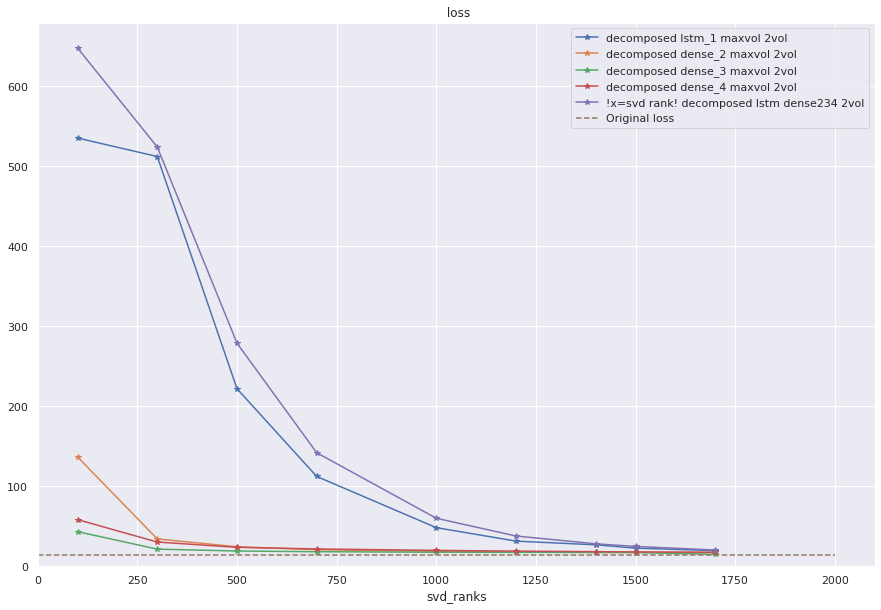

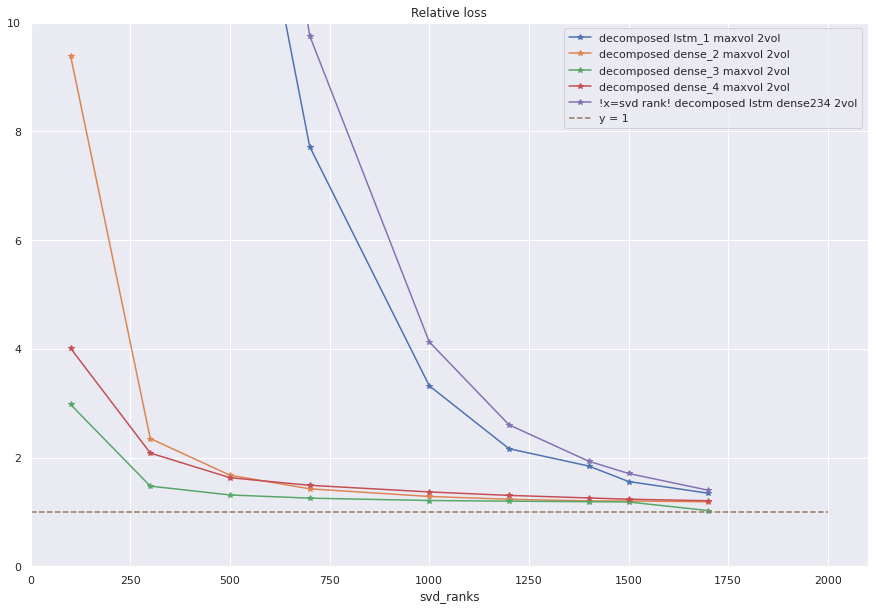

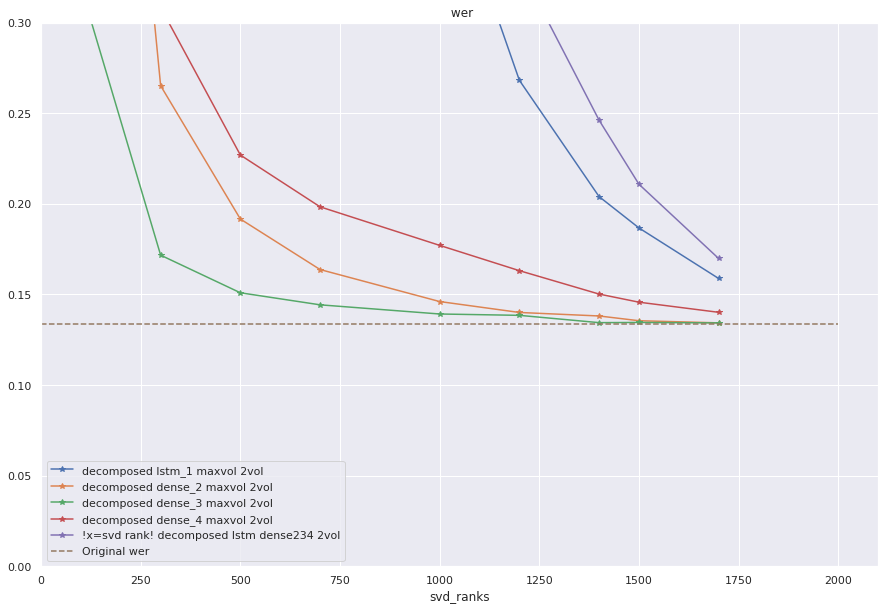

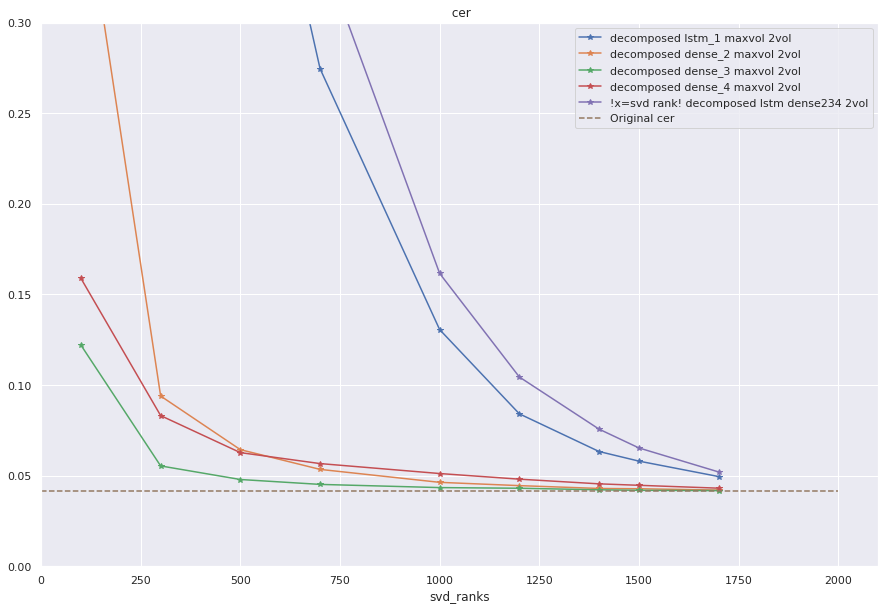

In [13]:
ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700]))
plot_metric_maxvol('losses', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
plot_metric_maxvol('losses', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)

plot_metric_maxvol('wers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('wers', ranks,['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('wers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('wers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)

# plot_metric_maxvol('cers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('cers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
plot_metric_maxvol('cers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('cers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)

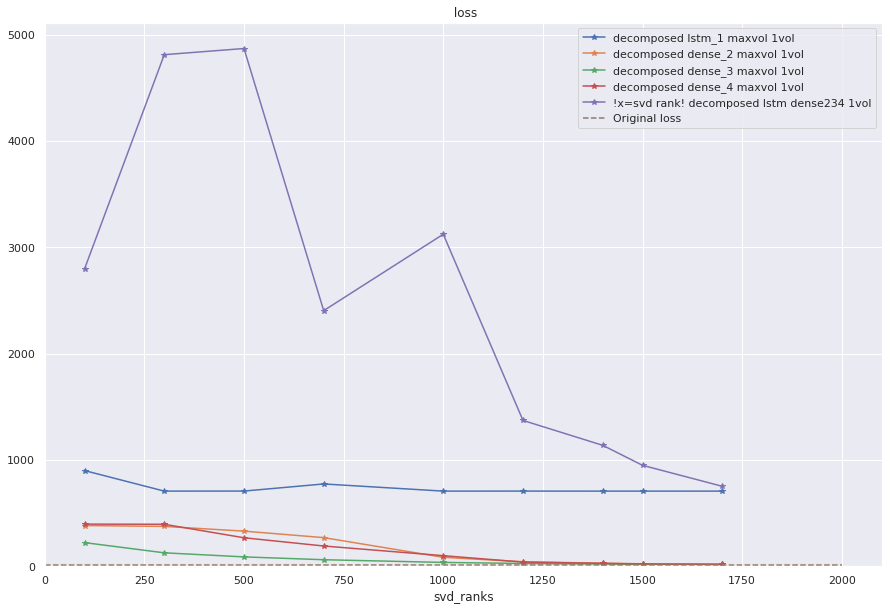

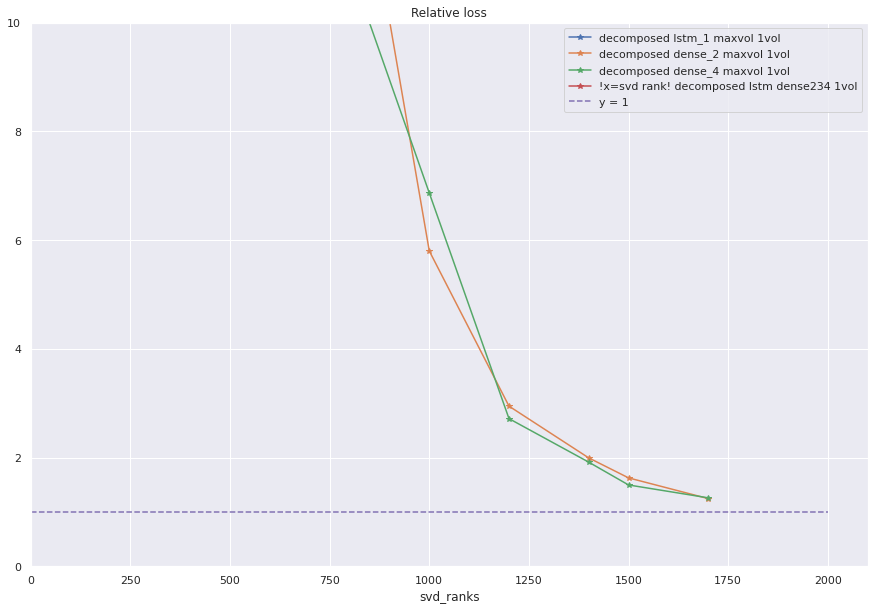

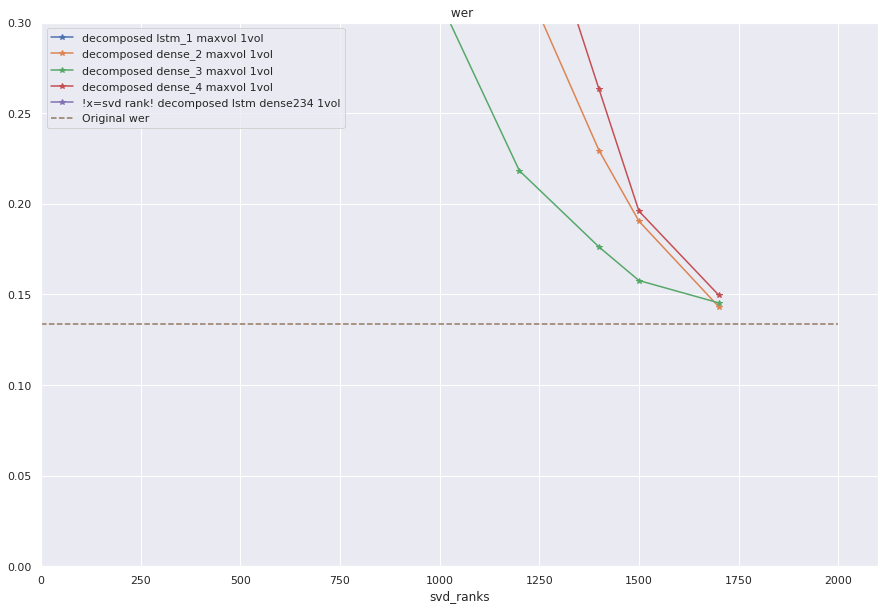

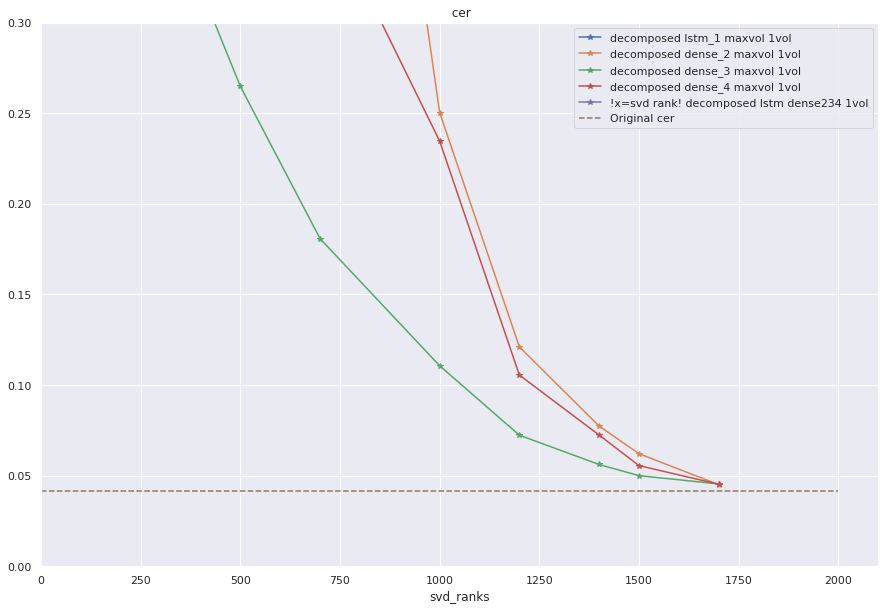

In [14]:
ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700]))
plot_metric_maxvol('losses', ranks, ['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
plot_metric_maxvol('losses', ranks, ['1vol'], ['lstm_1', 'dense_2', 'dense_4'], relative_values=True)

plot_metric_maxvol('wers', ranks, ['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('wers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)

plot_metric_maxvol('cers', ranks, ['1vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'])
# plot_metric_maxvol('cers', ranks, ['2vol'], ['lstm_1', 'dense_2', 'dense_3', 'dense_4'], relative_values=True)

# Speedup plot

In [15]:
def get_inf_times(ranks, maxvol_type, speed_data):
    inference_times = []
    for rank in ranks:
        inference_times.append(speed_data[f'lstm_desnse234_{maxvol_type}_maxvolled_deepspeech_r{rank}'][0])
    return np.array(inference_times)

In [18]:
with open('./maxvol_stats/speeduptest.pickle', 'rb') as f:
    speed_data = pickle.load(f)
    
def print_speedup_wer_plot(*args, xlim=None, ylim=None):
    assert len(args) == 0
    plt.figure(figsize=(14,10))
    
    ranks = list(reversed([100, 300, 500, 700, 1000, 1200, 1400, 1500, 1700]))
    wers = np.load(f'./maxvol_stats/1vol_wers.npy')
    speedups = 189101.0 / get_inf_times(ranks, '1vol', speed_data)
    plt.scatter(speedups, wers, label='1vol decomposed deepspeech')
    wers = np.load(f'./maxvol_stats/2vol_wers.npy')
    speedups = 189101.0 / get_inf_times(ranks, '2vol', speed_data) 
    plt.scatter(speedups, wers, label='2vol decomposed deepspeech')
    
    plt.scatter([1], [original_values['wer']],label='Original deepspeech perfomance', c='y')
    plt.ylabel('wer')
    plt.xlabel('speedup')
    plt.title(f'Error for maxvol decomposition of all layers')
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.legend()
    plt.show()    

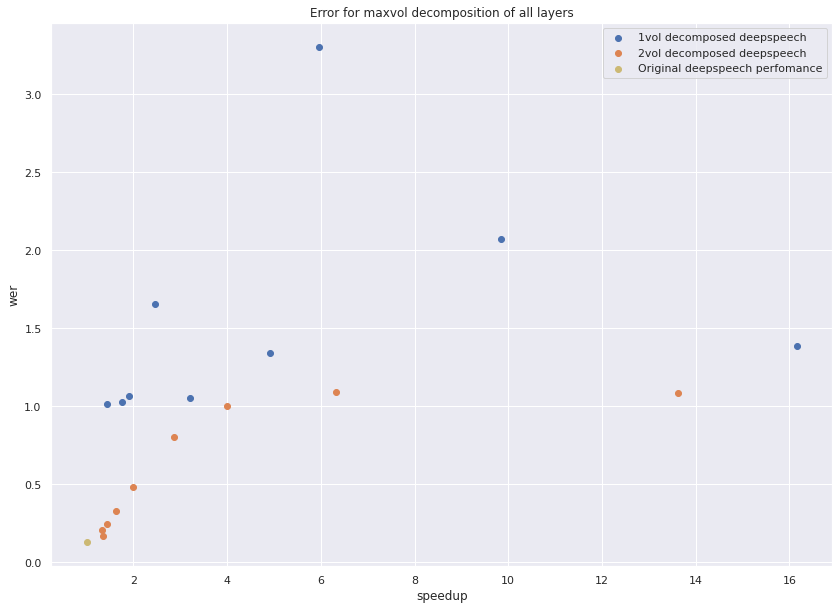

In [19]:
print_speedup_wer_plot()

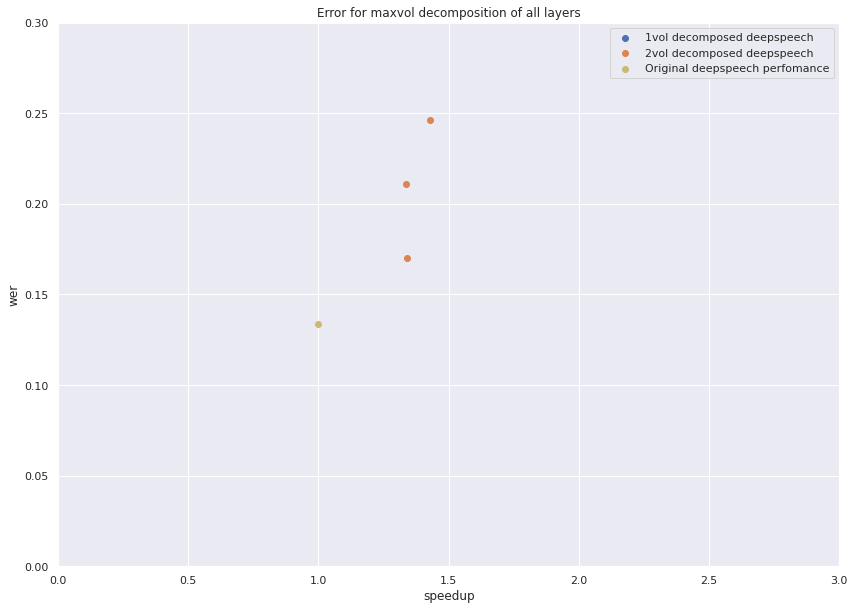

In [20]:
print_speedup_wer_plot(ylim=[0, 0.3], xlim=[0, 3])